# Loan Subgrade feature engineering

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go
import math
from termcolor import colored, cprint

from matplotlib.ticker import MaxNLocator, MultipleLocator
from matplotlib.dates import YearLocator, DateFormatter

import scipy.stats.distributions as dist
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

from dask import dataframe as dd
from df_squeezer import df_squeezer
import time
from fuzzywuzzy import process

from generic_functions import check_missing_values, value_counts_to_dataframe, pivot_dim2


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pca_functions import plot_variance, make_mi_scores

from sklearn import model_selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold



pd.set_option('display.max_columns', None)
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

os.getcwd()

'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/V2'

In [2]:
path_accept = '/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/data/accepted_2007_to_2018Q4.csv'
dtype_list = {'debt_settlement_flag_date': 'object',
       'desc': 'object',
       'hardship_end_date': 'object',
       'hardship_loan_status': 'object',
       'hardship_reason': 'object',
       'hardship_start_date': 'object',
       'hardship_status': 'object',
       'hardship_type': 'object',
       'payment_plan_start_date': 'object',
       'settlement_date': 'object',
       'settlement_status': 'object',
       'sec_app_earliest_cr_line': 'object',
       'id': 'object'}

In [3]:
%%time
df_accept = df_squeezer(pd.read_csv(path_accept),report=True, edit=True)
df_accept.head(2)

Suggested conversion for column 'member_id': float64 -> float32
Suggested conversion for column 'loan_amnt': float64 -> float32
Suggested conversion for column 'funded_amnt': float64 -> float32
Suggested conversion for column 'term': object -> category
Suggested conversion for column 'int_rate': float64 -> float32
Suggested conversion for column 'installment': float64 -> float32
Suggested conversion for column 'grade': object -> category
Suggested conversion for column 'sub_grade': object -> category
Suggested conversion for column 'emp_title': object -> category
Suggested conversion for column 'emp_length': object -> category
Suggested conversion for column 'home_ownership': object -> category
Suggested conversion for column 'verification_status': object -> category
Suggested conversion for column 'issue_d': object -> category
Suggested conversion for column 'loan_status': object -> category
Suggested conversion for column 'pymnt_plan': object -> category
Suggested conversion for colu

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.029999,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.910000,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.700001,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.200001,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.900002,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.280029,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.059999,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.200001,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.100000,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.400002,7.7,0.0,0.0,314017.0,39475

In [7]:
df_accept.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.029999,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.910000,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.700001,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.200001,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.900002,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.280029,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.059999,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.200001,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.100000,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.400002,7.7,0.0,0.0,314017.0,39475

In [4]:
cols = ['sub_grade','grade','issue_d',
        'loan_amnt','installment','annual_inc',
        'dti','fico_range_low','fico_range_high',
        'inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util',
        'delinq_2yrs','mths_since_last_delinq',
        'term','emp_title','emp_length',
        'home_ownership','verification_status',
        'purpose','addr_state','application_type']


df_a = df_squeezer(df_accept[cols], report=True, edit=True)
print('Dataset lenght before null values removal', df_a.shape)

# We will remove categorical attributes reconds with null values 
df_a = df_a[(df_a.issue_d.isna() == False)
           &
           (df_a.emp_length.isna() == False)
           &
           (df_a.emp_title.isna() == False)].reset_index()
df_a = df_a.drop(columns=['index'])
df_a.info()
df_a.head(3)


Original total memory usage: 207.38 MB
New total memory usage: 207.38 MB
Memory saved: 0 Bytes

# Executable Python code for suggested dtype conversions:
Dataset lenght before null values removal (2260701, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2092901 entries, 0 to 2092900
Data columns (total 24 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   sub_grade               category
 1   grade                   category
 2   issue_d                 category
 3   loan_amnt               float32 
 4   installment             float32 
 5   annual_inc              float64 
 6   dti                     float32 
 7   fico_range_low          float32 
 8   fico_range_high         float32 
 9   inq_last_6mths          float32 
 10  open_acc                float32 
 11  pub_rec                 float32 
 12  revol_bal               float32 
 13  revol_util              float32 
 14  delinq_2yrs             float32 
 15  mths_since_last_delinq  f

,sub_grade,grade,issue_d,loan_amnt,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,delinq_2yrs,mths_since_last_delinq,term,emp_title,emp_length,home_ownership,verification_status,purpose,addr_state,application_type
0,C4,C,Dec-2015,3600.0,123.029999,55000.0,5.910000,675.0,679.0,1.0,7.0,0.0,2765.0,29.700001,0.0,30.0,36 months,leadman,10+ years,MORTGAGE,Not Verified,debt_consolidation,PA,Individual
1,C1,C,Dec-2015,24700.0,820.280029,65000.0,16.059999,715.0,719.0,4.0,22.0,0.0,21470.0,19.200001,1.0,6.0,36 months,Engineer,10+ years,MORTGAGE,Not Verified,small_business,SD,Individual
2,B4,B,Dec-2015,20000.0,432.660004,63000.0,10.780000,695.0,699.0,0.0,6.0,0.0,7869.0,56.200001,0.0,NaN,60 months,truck driver,10+ years,MORTGAGE,Not Verified,home_improvement,IL,Joint App


## Employment title standartisation

In [5]:
# Generic employment categories
employment_categories = {
    "nurse": ["nurse"],
    "teacher": ["teacher"],
    "driver": ["driver"],
    "analyst": ["analyst"],
    "engineer": ["engineer","mechanic","technician","electrician"],
    "accountant": ["accountant","administrative"],
    "legal": ["attorney","paralegal"],
    "sales": ["sales","customer","operator","consultant"],
    "police": ["police","controller"],
    "supervisor": ["supervisor"],
    "owner": ["owner"],
    "sales": ["sales"],
    "manager": ["manager","leadman"],
    "director": ["director","president","ceo"]
}

def assign_category(title:str) -> str:
    """
    Function to assign generic category to employment title
    """
    # Convert to lowercase for case-insensitive matching
    title = title.lower() 
    for category, keywords in employment_categories.items():
        for keyword in keywords:
            if keyword in title:
                return category
    # Default category if no match is found
    return "other"  

In [6]:
df_a['emp_title_agg'] = df_a.emp_title.apply(lambda x: assign_category(x))

df_a[['emp_title','emp_title_agg']].head(20)
(df_a.groupby('emp_title_agg')
     .agg(Occur=('issue_d','count'))
     .reset_index()
     .sort_values(by='Occur',ascending = False)
     .head(20))

,emp_title_agg,Occur
8,other,1127825
6,manager,286790
4,engineer,122669
2,director,106466
11,sales,74091
13,teacher,59350
12,supervisor,58420
3,driver,52713
1,analyst,51787
7,nurse,46739


## Loans issued year

In [7]:
df_a['year'] = df_a.issue_d.apply(lambda x: x.split('-')[1])
df_a[['year','issue_d']].head(2)

,year,issue_d
0,2015,Dec-2015
1,2015,Dec-2015


## Loan term standartisation

In [8]:
df_a.term.unique()

[' 36 months', ' 60 months']
Categories (2, object): [' 36 months', ' 60 months']

In [9]:
df_a['term'] = df_a.term.apply(lambda x: int(x.replace(" ","").replace("months","")))

In [10]:
df_a.term.unique()

[36, 60]
Categories (2, int64): [36, 60]

## Verification status standartisation

In [11]:
df_a.verification_status.unique()

['Not Verified', 'Source Verified', 'Verified']
Categories (3, object): ['Not Verified', 'Source Verified', 'Verified']

In [12]:
df_a['verification_status'] = df_a.verification_status.apply(lambda x: x.replace(" ","_"))

In [13]:
df_a.verification_status.unique()

['Not_Verified', 'Source_Verified', 'Verified']
Categories (3, object): ['Not_Verified', 'Source_Verified', 'Verified']

## Aplication type standartisation

In [14]:
df_a.application_type.unique()

['Individual', 'Joint App']
Categories (2, object): ['Individual', 'Joint App']

In [15]:
df_a['application_type'] = df_a.application_type.apply(lambda x: x.replace(" ","_"))

In [16]:
df_a.application_type.unique()

['Individual', 'Joint_App']
Categories (2, object): ['Individual', 'Joint_App']

## Tartget and features selections

In [18]:
df = df_a[['sub_grade','grade','year','loan_amnt','installment','annual_inc',
        'dti','fico_range_low','fico_range_high',
        'inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util',
        'delinq_2yrs','mths_since_last_delinq',
        'term','emp_title_agg','emp_length',
        'home_ownership','verification_status',
        'purpose','addr_state','application_type']]
df.head(2)

,sub_grade,grade,year,loan_amnt,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,delinq_2yrs,mths_since_last_delinq,term,emp_title_agg,emp_length,home_ownership,verification_status,purpose,addr_state,application_type
0,C4,C,2015,3600.0,123.029999,55000.0,5.910000,675.0,679.0,1.0,7.0,0.0,2765.0,29.700001,0.0,30.0,36,manager,10+ years,MORTGAGE,Not_Verified,debt_consolidation,PA,Individual
1,C1,C,2015,24700.0,820.280029,65000.0,16.059999,715.0,719.0,4.0,22.0,0.0,21470.0,19.200001,1.0,6.0,36,engineer,10+ years,MORTGAGE,Not_Verified,small_business,SD,Individual


In [19]:
print(list(df.sub_grade.unique()))

['C4', 'C1', 'B4', 'C5', 'F1', 'C3', 'B2', 'B1', 'A2', 'B5', 'C2', 'E2', 'A4', 'E3', 'A1', 'D4', 'F3', 'D1', 'B3', 'E4', 'D3', 'D2', 'D5', 'A5', 'F2', 'E1', 'F5', 'E5', 'A3', 'G2', 'G1', 'G3', 'G4', 'F4', 'G5']


## Check duplicates

In [20]:
def check_duplicates(df:DataFrame) -> str:
    """This function checks if dataframe length is same
    after the duplicate rows removal"""
    
    print('Dataset has records:',len(df))
    print('Dataset has duplicates:',len(df)-len(df.drop_duplicates()))
          
    if len(df) == len(df.drop_duplicates()):
        print('Table does not have duplicate rows')
    else:
        print(colored('Table has duplicates rows','red'))

In [21]:
check_duplicates(df)

Dataset has records: 2092901
Dataset has duplicates: 0
Table does not have duplicate rows


## Target distribution

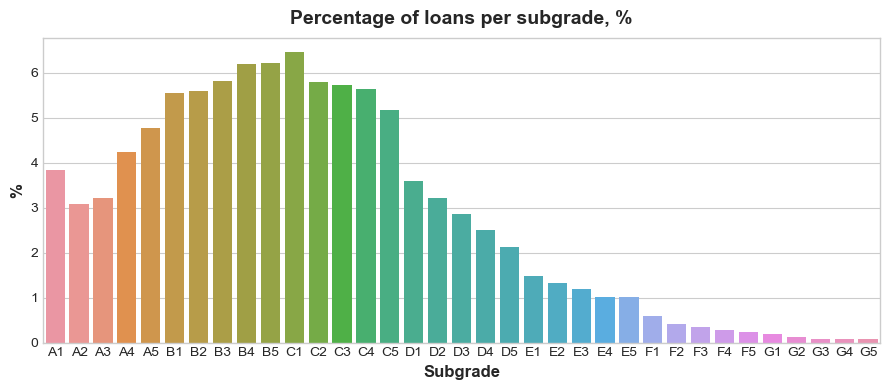

In [36]:
attrib = 'sub_grade'
temp_df = value_counts_to_dataframe(df,attrib)

# fig = px.pie(temp_df, values='counts', 
#        names='sub_grade', 
#        hole=.5,
#        title=f'Percentage of loans per subgrade, %')
# fig.show()

plt.figure(figsize = (9, 4))

sns.barplot(x=temp_df['sub_grade'], y=temp_df['proportion'])
plt.xlabel('Subgrade')
plt.ylabel('%')
plt.title('Percentage of loans per subgrade, %')

plt.show()

We have imbalanced target dataset, subgrades distributes different proportions

In [38]:
print(list(df.sub_grade.unique()))

['C4', 'C1', 'B4', 'C5', 'F1', 'C3', 'B2', 'B1', 'A2', 'B5', 'C2', 'E2', 'A4', 'E3', 'A1', 'D4', 'F3', 'D1', 'B3', 'E4', 'D3', 'D2', 'D5', 'A5', 'F2', 'E1', 'F5', 'E5', 'A3', 'G2', 'G1', 'G3', 'G4', 'F4', 'G5']


In [39]:
subgrade_map = {'A1': 0, 'A2': 1,'A3': 2,'A4': 3,'A5': 4,
             'B1': 5, 'B2': 6,'B3': 7,'B4': 8,'B5': 9,
             'C1': 10, 'C2': 11,'C3': 12,'C4': 13,'C5': 14,
             'D1': 15, 'D2': 16,'D3': 17,'D4': 18,'D5': 19,
             'E1': 20, 'E2': 21,'E3': 22,'E4': 23,'E5': 24,
             'F1': 25, 'F2': 26,'F3': 27,'F4': 28,'F5': 29,
             'G1': 30, 'G2': 31,'G3': 32,'G4': 33,'G5': 34}

df['sub_grade'] = df.sub_grade.apply(lambda x: subgrade_map[x])
df.sub_grade.unique()

[13, 10, 8, 14, 25, ..., 30, 32, 33, 28, 34]
Length: 35
Categories (35, int64): [0, 1, 2, 3, ..., 31, 32, 33, 34]

# Features engineering

## Training and Test samples slit

In [40]:
features = ['year','grade','loan_amnt','installment','annual_inc',
        'dti','fico_range_low','fico_range_high',
        'inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util',
        'delinq_2yrs','mths_since_last_delinq',
        'term','emp_title_agg','emp_length',
        'home_ownership','verification_status',
        'purpose','addr_state','application_type']

target = ['sub_grade']

In [54]:
# X , y = df[features],df[target]
X , y = df[df.year == '2018'][features],df[df.year == '2018'][target]

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [55]:
print('Training sample', x_train.shape)
print('Test sample', x_test.shape)

Training sample (352444, 23)
Test sample (88111, 23)


## Check & handling missing values

<b>Training dataset:</b>

In [56]:
check_missing_values(x_train)
print(x_train.isna().sum())

Table has missing values
year                           0
grade                          0
loan_amnt                      0
installment                    0
annual_inc                     0
dti                           38
fico_range_low                 0
fico_range_high                0
inq_last_6mths                 0
open_acc                       0
pub_rec                        0
revol_bal                      0
revol_util                   395
delinq_2yrs                    0
mths_since_last_delinq    195856
term                           0
emp_title_agg                  0
emp_length                     0
home_ownership                 0
verification_status            0
purpose                        0
addr_state                     0
application_type               0
dtype: int64


In [57]:
x_train['dti'] = x_train['dti'].fillna(round(x_train['dti'].median(),2))
x_train['inq_last_6mths'] = x_train['inq_last_6mths'].fillna(round(x_train['inq_last_6mths'].median(),2))
x_train['open_acc'] = x_train['open_acc'].fillna(round(x_train['open_acc'].median(),2))
x_train['pub_rec'] = x_train['pub_rec'].fillna(round(x_train['pub_rec'].median(),2))
x_train['revol_util'] = x_train['revol_util'].fillna(round(x_train['revol_util'].median(),2))
x_train['delinq_2yrs'] = x_train['delinq_2yrs'].fillna(round(x_train['delinq_2yrs'].median(),2))
x_train['mths_since_last_delinq'] = x_train['mths_since_last_delinq'].fillna(round(x_train['mths_since_last_delinq'].median(),2))

<b>Test dataset:<b>

In [58]:
check_missing_values(x_test)
print(x_test.isna().sum())

Table has missing values
year                          0
grade                         0
loan_amnt                     0
installment                   0
annual_inc                    0
dti                          21
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                   97
delinq_2yrs                   0
mths_since_last_delinq    49093
term                          0
emp_title_agg                 0
emp_length                    0
home_ownership                0
verification_status           0
purpose                       0
addr_state                    0
application_type              0
dtype: int64


In [59]:
x_test['dti'] = x_test['dti'].fillna(round(x_test['dti'].median(),2))
x_test['inq_last_6mths'] = x_test['inq_last_6mths'].fillna(round(x_test['inq_last_6mths'].median(),2))
x_test['open_acc'] = x_test['open_acc'].fillna(round(x_test['open_acc'].median(),2))
x_test['pub_rec'] = x_test['pub_rec'].fillna(round(x_test['pub_rec'].median(),2))
x_test['revol_util'] = x_test['revol_util'].fillna(round(x_test['revol_util'].median(),2))
x_test['delinq_2yrs'] = x_test['delinq_2yrs'].fillna(round(x_test['delinq_2yrs'].median(),2))
x_test['mths_since_last_delinq'] = x_test['mths_since_last_delinq'].fillna(round(x_test['mths_since_last_delinq'].median(),2))

## Ordinal encoder

In [60]:
object_cols_ordinal = ['year','grade','emp_length','term']

In [61]:
ordinal_encoder = OrdinalEncoder()

x_train[object_cols_ordinal] = ordinal_encoder.fit_transform(x_train[object_cols_ordinal])
x_test[object_cols_ordinal] = ordinal_encoder.transform(x_test[object_cols_ordinal])

x_test[object_cols_ordinal].head(3)

,year,grade,emp_length,term
724614,0.0,0.0,1.0,0.0
723645,0.0,0.0,0.0,0.0
397895,0.0,0.0,1.0,0.0


## One-Hot Encoding

In [62]:
object_cols_category = ['emp_title_agg','home_ownership','verification_status','purpose',
                       'application_type','addr_state']

In [63]:
OH_encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

labels = list(x_train.emp_title_agg.unique())
ohe = ColumnTransformer(
    transformers=[("ohe", OH_encoder, object_cols_category),],
    remainder="passthrough",
)
ohe.set_output(transform="pandas")

OH_cols_train = pd.DataFrame(ohe.fit_transform(x_train[object_cols_category]))
OH_cols_test = pd.DataFrame(ohe.transform(x_test[object_cols_category]))

# Remove categorical columns (will replace with one-hot encoding)
num_x_train = x_train.drop(object_cols_category, axis=1)
num_x_test = x_test.drop(object_cols_category, axis=1)

# # Add one-hot encoded columns to numerical features
x_train = pd.concat([num_x_train, OH_cols_train], axis=1)
x_test = pd.concat([num_x_test, OH_cols_test], axis=1)

In [64]:
x_test.head(3)

,year,grade,loan_amnt,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,delinq_2yrs,mths_since_last_delinq,term,emp_length,ohe__emp_title_agg_accountant,ohe__emp_title_agg_analyst,ohe__emp_title_agg_director,ohe__emp_title_agg_driver,ohe__emp_title_agg_engineer,ohe__emp_title_agg_legal,ohe__emp_title_agg_manager,ohe__emp_title_agg_nurse,ohe__emp_title_agg_other,ohe__emp_title_agg_owner,ohe__emp_title_agg_police,ohe__emp_title_agg_sales,ohe__emp_title_agg_supervisor,ohe__emp_title_agg_teacher,ohe__home_ownership_ANY,ohe__home_ownership_MORTGAGE,ohe__home_ownership_OWN,ohe__home_ownership_RENT,ohe__verification_status_Not_Verified,ohe__verification_status_Source_Verified,ohe__verification_status_Verified,ohe__purpose_car,ohe__purpose_credit_card,ohe__purpose_debt_consolidation,ohe__purpose_home_improvement,ohe__purpose_house,ohe__purpose_major_purchase,ohe__purpose_medical,ohe__purpose_moving,ohe__purpose_other,ohe__purpose_renewable_energy,ohe__purpose_small_business,ohe__purpose_vacation,ohe__purpose_wedding,ohe__application_type_Individual,ohe__application_type_Joint_App,ohe__addr_state_AK,ohe__addr_state_AL,ohe__addr_state_AR,ohe__addr_state_AZ,ohe__addr_state_CA,ohe__addr_state_CO,ohe__addr_state_CT,ohe__addr_state_DC,ohe__addr_state_DE,ohe__addr_state_FL,ohe__addr_state_GA,ohe__addr_state_HI,ohe__addr_state_ID,ohe__addr_state_IL,ohe__addr_state_IN,ohe__addr_state_KS,ohe__addr_state_KY,ohe__addr_state_LA,ohe__addr_state_MA,ohe__addr_state_MD,ohe__addr_state_ME,ohe__addr_state_MI,ohe__addr_state_MN,ohe__addr_state_MO,ohe__addr_state_MS,ohe__addr_state_MT,ohe__addr_state_NC,ohe__addr_state_ND,ohe__addr_state_NE,ohe__addr_state_NH,ohe__addr_state_NJ,ohe__addr_state_NM,ohe__addr_state_NV,ohe__addr_state_NY,ohe__addr_state_OH,ohe__addr_state_OK,ohe__addr_state_OR,ohe__addr_state_PA,ohe__addr_state_RI,ohe__addr_state_SC,ohe__addr_state_SD,ohe__addr_state_TN,ohe__addr_state_TX,ohe__addr_state_UT,ohe__addr_state_VA,ohe__addr_state_VT,ohe__addr_state_WA,ohe__addr_state_WI,ohe__addr_state_WV,ohe__addr_state_WY
724614,0.0,0.0,11000.0,343.890015,41000.0,30.440001,715.0,719.0,0.0,13.0,0.0,15247.0,74.0,0.0,34.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
723645,0.0,0.0,5300.0,162.860001,50000.0,23.379999,725.0,729.0,1.0,17.0,0.0,12015.0,31.1,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397895,0.0,0.0,30000.0,903.309998,160000.0,19.350000,725.0,729.0,1.0,23.0,0.0,26376.0,26.9,0.0,34.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

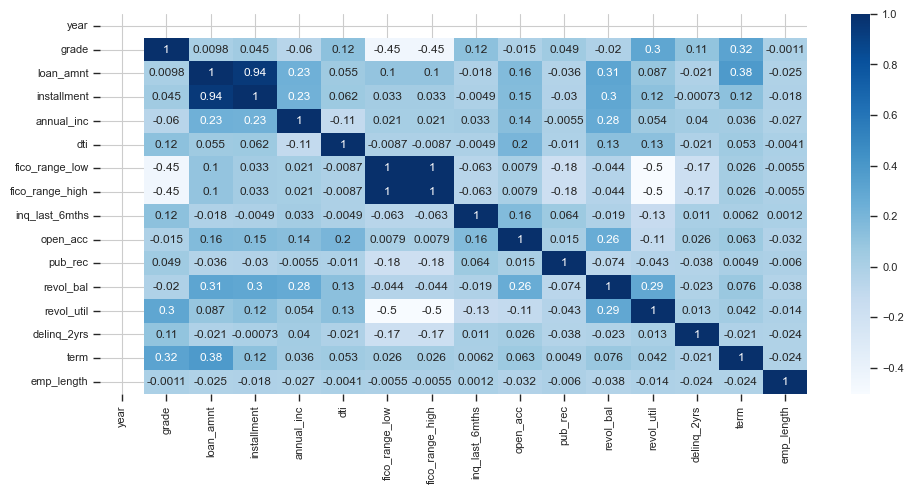

In [65]:
num_cols = ['year','grade','loan_amnt','installment','annual_inc',
           'dti','fico_range_low','fico_range_high','inq_last_6mths',
            'open_acc','pub_rec','revol_bal','revol_util','delinq_2yrs',
            'term','emp_length']

plt.figure(figsize = (10,5))

sns.set_context("paper", font_scale=0.9) 

sns.heatmap(x_train[num_cols].corr(), 
        annot=True,
        cmap="Blues")

In [66]:
# path_train = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/V2/output/subgrade/x_train.csv'
# path_test = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/V2/output/subgrade/x_test.csv'
path_train = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/V2/output/subgrade/sample/x_train.csv'
path_test = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/V2/output/subgrade/sample/x_test.csv'


x_train.to_csv(path_train,index=False)
x_test.to_csv(path_test,index=False)

# path_ytrain = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/V2/output/subgrade/y_train.csv'
# path_ytest = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/V2/output/subgrade/y_test.csv'
path_ytrain = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/V2/output/subgrade/sample/y_train.csv'
path_ytest = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/V2/output/subgrade/sample/y_test.csv'
y_train.to_csv(path_ytrain,index=False)
y_test.to_csv(path_ytest,index=False)